In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import urllib.parse
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn import tree

In [2]:
df_train = pd.read_csv('./Doceree_HCP_Train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('./Doceree_HCP_Test.csv',encoding='ISO-8859-1')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               113937 non-null  int64  
 1   DEVICETYPE       113937 non-null  object 
 2   PLATFORM_ID      113937 non-null  int64  
 3   BIDREQUESTIP     113937 non-null  object 
 4   USERPLATFORMUID  113933 non-null  object 
 5   USERCITY         107578 non-null  object 
 6   USERZIPCODE      109345 non-null  float64
 7   USERAGENT        113935 non-null  object 
 8   PLATFORMTYPE     113937 non-null  object 
 9   CHANNELTYPE      113937 non-null  object 
 10  URL              113937 non-null  object 
 11  KEYWORDS         113937 non-null  object 
 12  TAXONOMY         32313 non-null   object 
 13  IS_HCP           113936 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 12.2+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               28580 non-null  object 
 1   DEVICETYPE       28550 non-null  object 
 2   PLATFORM_ID      28530 non-null  float64
 3   BIDREQUESTIP     28530 non-null  object 
 4   USERPLATFORMUID  28530 non-null  object 
 5   USERCITY         26936 non-null  object 
 6   USERZIPCODE      27380 non-null  float64
 7   USERAGENT        28529 non-null  object 
 8   PLATFORMTYPE     28530 non-null  object 
 9   CHANNELTYPE      28530 non-null  object 
 10  URL              28530 non-null  object 
 11  KEYWORDS         28510 non-null  object 
dtypes: float64(2), object(10)
memory usage: 2.6+ MB


In [5]:
df_train.head()

,ID,DEVICETYPE,PLATFORM_ID,BIDREQUESTIP,USERPLATFORMUID,USERCITY,USERZIPCODE,USERAGENT,PLATFORMTYPE,CHANNELTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,1001,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
1,1002,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/deci...,Bone Marrow|Radiography|Chronic|Oncology|Psych...,NaN,0.0
2,1003,Desktop,2,66.232.79.22,a698de4b-e200-46dd-b5fb-40402175ae18,New Meadows,83654.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
3,1004,Desktop,3,137.54.125.246,45967533-75c8-4fbd-a00c-e6ff20447aaa,NaN,229114624.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,https://globalrph.com/medcalcs/warfarin-mainte...,Dental|Total|Clinical|Pharmacology|Physicians|...,2084P0800X,1.0
4,1005,Mobile,7,174.202.231.99,a17e25be-532d-4cf5-b916-9308c8c3961f,Houston,77008.0,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1_1 like...,Online Medical Journal,Website,https://www.cureus.com/articles/58184-a-review...,Critical Care|Emergency Medicine|General Pract...,NaN,0.0


In [6]:
print("no. of rows: ",df_train.shape[0], "\n""no. of columns: ",df_train.shape[1])
print("no. of rows: ",df_test.shape[0], "\n""no. of columns: ",df_test.shape[1])

no. of rows:  113937 
no. of columns:  14
no. of rows:  28580 
no. of columns:  12


In [7]:
df_train.duplicated().sum()

0

In [8]:
df_test.drop('USERZIPCODE',axis=1,inplace=True)
df_test.drop('PLATFORM_ID',axis=1,inplace=True)

In [9]:
# Impute null values with the mode of each column
categorical_columns = df_test.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

In [10]:
duplicate_rows = df_test.duplicated()

# Handle duplicate rows
if duplicate_rows.any():
    # Create a new column to mark duplicate rows
    df_test['is_duplicate'] = duplicate_rows.astype(int)
    # Optionally, you can keep the first occurrence and mark subsequent duplicates as non-duplicates
    df_test.loc[duplicate_rows, 'is_duplicate'] = 0


In [11]:
df_test.describe()

,is_duplicate
count,28580.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [12]:
df_test.isnull().sum()

ID                 0
DEVICETYPE         0
BIDREQUESTIP       0
USERPLATFORMUID    0
USERCITY           0
USERAGENT          0
PLATFORMTYPE       0
CHANNELTYPE        0
URL                0
KEYWORDS           0
is_duplicate       0
dtype: int64

In [13]:
df_test.isnull().sum()

ID                 0
DEVICETYPE         0
BIDREQUESTIP       0
USERPLATFORMUID    0
USERCITY           0
USERAGENT          0
PLATFORMTYPE       0
CHANNELTYPE        0
URL                0
KEYWORDS           0
is_duplicate       0
dtype: int64

In [14]:
df_test.shape

(28580, 11)

In [15]:
#df_test = df_test.drop_duplicates(subset=['DEVICETYPE', 'BIDREQUESTIP','PLATFORM_ID', 'USERPLATFORMUID', 'USERCITY', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE', 'URL', 'KEYWORDS'],ignore_index=True)
#df_test.drop_duplicates(inplace=True, ignore_index=True)

In [16]:
df_test.duplicated().sum()

33

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               28580 non-null  object
 1   DEVICETYPE       28580 non-null  object
 2   BIDREQUESTIP     28580 non-null  object
 3   USERPLATFORMUID  28580 non-null  object
 4   USERCITY         28580 non-null  object
 5   USERAGENT        28580 non-null  object
 6   PLATFORMTYPE     28580 non-null  object
 7   CHANNELTYPE      28580 non-null  object
 8   URL              28580 non-null  object
 9   KEYWORDS         28580 non-null  object
 10  is_duplicate     28580 non-null  int32 
dtypes: int32(1), object(10)
memory usage: 2.3+ MB


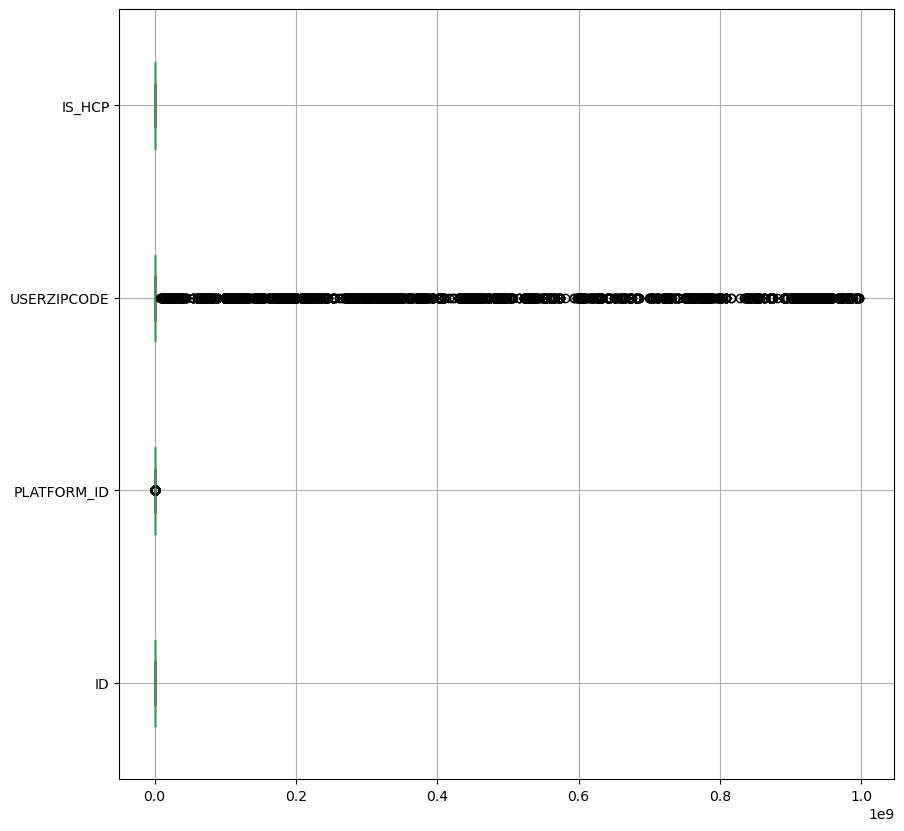

In [18]:
plt.figure(figsize=(10,10))
df_train.boxplot(vert=0)
plt.show()

<AxesSubplot:xlabel='DEVICETYPE', ylabel='IS_HCP'>

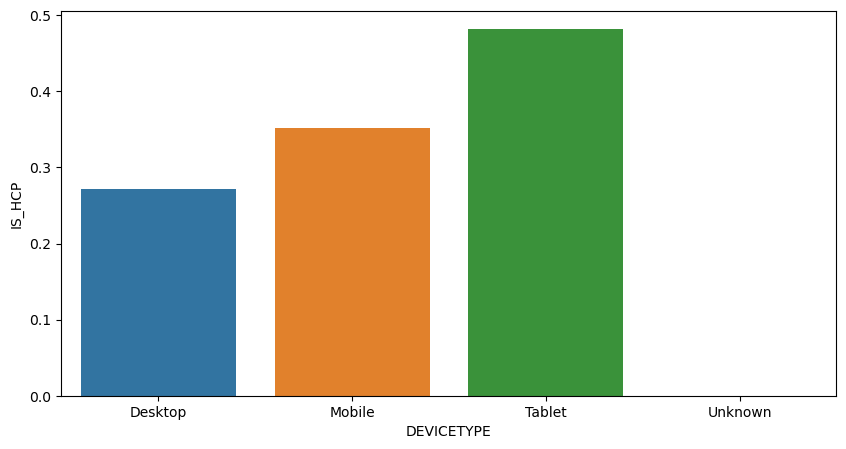

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(df_train.DEVICETYPE,df_train.IS_HCP,ci=None)

<AxesSubplot:xlabel='PLATFORM_ID', ylabel='IS_HCP'>

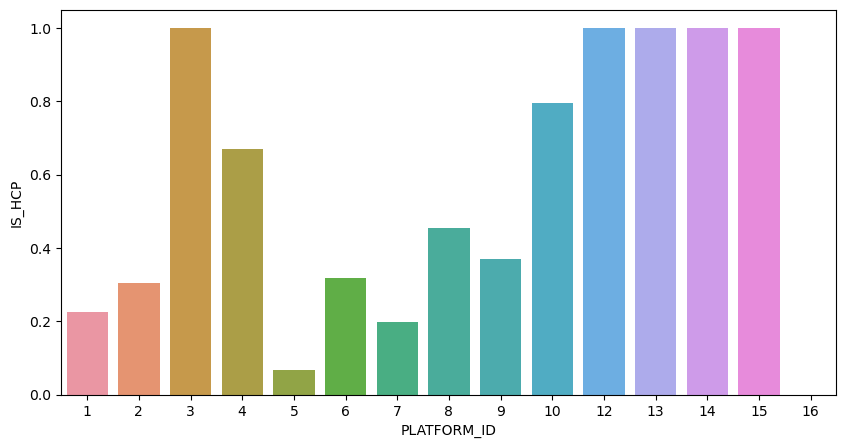

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(df_train.PLATFORM_ID,df_train.IS_HCP,ci=None)

<AxesSubplot:xlabel='CHANNELTYPE', ylabel='IS_HCP'>

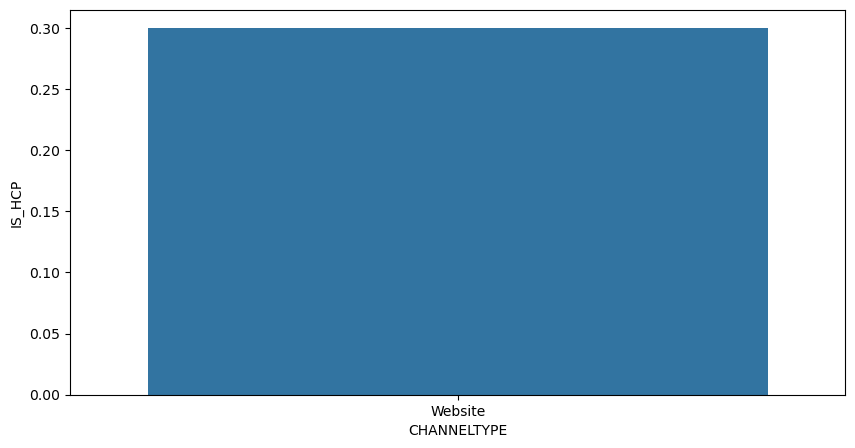

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(df_train.CHANNELTYPE,df_train.IS_HCP,ci=None)

In [22]:
#df_test.dropna(subset=['URL'], inplace=True)
#df_test['ID'] = df_test['ID'].astype(int)


In [23]:
# Function to convert IP address to numerical feature

def ip_to_numeric(ip):
    octets = ip.split('.')
    binary = ''.join([format(int(octet), '08b') for octet in octets])
    decimal = int(binary, 2)
    return decimal

# Apply the conversion function to the IP address column
df_train['BIDREQUESTIP'] = df_train['BIDREQUESTIP'].apply(ip_to_numeric)

# Print the updated dataframe
print(df_train)


            ID DEVICETYPE  PLATFORM_ID  BIDREQUESTIP  \
0         1001    Desktop            2    2863464470   
1         1002    Desktop            2    1104739609   
2         1003    Desktop            2    1122520854   
3         1004    Desktop            3    2302049782   
4         1005     Mobile            7    2932533091   
...        ...        ...          ...           ...   
113932  114933    Desktop            2    1146249598   
113933  114934    Desktop            2    1756105581   
113934  114935    Desktop            7    2920636017   
113935  114936     Mobile            2    1174241667   
113936  114937     Mobile            2    1814686127   

                             USERPLATFORMUID      USERCITY  USERZIPCODE  \
0       6974dcaa-f932-480e-9fb5-c52e20e1393a      Portland      97206.0   
1       c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf     Arlington      22202.0   
2       a698de4b-e200-46dd-b5fb-40402175ae18   New Meadows      83654.0   
3       45967533-75c8-4fbd-

In [24]:

# Function to convert IP address to numerical feature
def ip_to_numeric(ip):
    octets = ip.split('.')
    binary = ''.join([format(int(octet), '08b') for octet in octets])
    decimal = int(binary, 2)
    return decimal

# Apply the conversion function to the IP address column
df_test['BIDREQUESTIP'] = df_test['BIDREQUESTIP'].apply(ip_to_numeric)




In [25]:
cat=[]
num=[]
for i in df_train.columns:
    if df_train[i].dtype=="object":
        cat.append(i)
    else:
        num.append(i)
print(cat) 
print('/n ')
print(num)


['DEVICETYPE', 'USERPLATFORMUID', 'USERCITY', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE', 'URL', 'KEYWORDS', 'TAXONOMY']
/n 
['ID', 'PLATFORM_ID', 'BIDREQUESTIP', 'USERZIPCODE', 'IS_HCP']


In [26]:
cat_test=[]
num_test=[]
for i in df_test.columns:
    if df_test[i].dtype=="object":
        cat_test.append(i)
    else:
        num_test.append(i)
print(cat_test) 
print('/n ')
print(num_test)


['ID', 'DEVICETYPE', 'USERPLATFORMUID', 'USERCITY', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE', 'URL', 'KEYWORDS']
/n 
['BIDREQUESTIP', 'is_duplicate']


In [27]:
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        print(column.upper(),': ',df_train[column].nunique())
        print(df_train[column].value_counts().sort_values())
        print('\n')

DEVICETYPE :  4
Unknown       24
Tablet      3425
Mobile     32065
Desktop    78423
Name: DEVICETYPE, dtype: int64


USERPLATFORMUID :  53780
ce1e65a6-0d27-448d-b65c-3dc95c4fee4b       1
9fd00368-515b-4740-a23a-562c827b72fe       1
c19cdfe3-a995-4df2-b257-37371c17f868       1
7bd6ecee-4766-4400-9842-ef627fb1adec       1
9d327b4c-bfd7-4980-a10a-2ac6d22502c3       1
                                        ... 
fe53f32c-4646-4abe-afea-90b21d6b8531     617
fcd3d327-0ad5-425e-8ea8-33ffe6a31543     629
d00f28d6-3a50-46cd-92f3-8601bd57ad0e     675
d76f7c0b-1a64-4d4b-b36d-86c832be8837    1406
3e2578c8-f794-41af-a38c-c5cfb3c0f014    1447
Name: USERPLATFORMUID, Length: 53780, dtype: int64


USERCITY :  4420
Gambier            1
Dillsboro          1
Hawkinsville       1
Ellsworth          1
Wendell            1
                ... 
Houston         1747
Los Angeles     2154
St Louis        2545
Brooklyn        3237
New York        4943
Name: USERCITY, Length: 4420, dtype: int64


USERAGENT :  4288

KEYWORDS :  2460
the|lung|educational|pneumonia|radiology|pulmonary fibrosis|dyspnea|technology|pleural effusion|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               1
small|nephrology|radiology|preventive 

In [28]:
for column in df_test.columns:
    if df_test[column].dtype == 'object':
        print(column.upper(),': ',df_test[column].nunique())
        print(df_test[column].value_counts().sort_values())
        print('\n')

ID :  28547
139271                                  1
115509                                  1
115510                                  1
115511                                  1
115512                                  1
                                       ..
¡[                                      3
wãUU~-(®á38332747)-ñ3ãU9(Qd            3
¡]s¹P-')<¯H~Ð[ÛQÙ¹k489.com     4
®átou694\t.slt                      7
è                                      16
Name: ID, Length: 28547, dtype: int64


DEVICETYPE :  13
hospitals|nephrology|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|pulmonary fibrosis|ophthalmology|chronic|neurology|heart failure|disease|health|medicine|hidradenitis suppurativa|gastroenterology|cardiology|the|clinical|dermatology|pediatrics|surgery|endocrinology|            1
hospitals|covid|nephrology|myocardial infarction|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|ophthalmology|chronic|neurology|disease|health|covid-

Angioedema|Arthropathy|Cardiology|Age Groups|Clinical|Experimental|False|Oncology|Physicians|Health|Thyroid Carcinoma|Child|Hereditary|Acquired|Gastroenterology|Rheumatology|Multiple Sclerosis|Technology|Dermatology|Urology|Hepatology|Total|Neurology                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1
small|chronic kidney disease|nephrology|radiology|elderly|preventive medicine|critical care|internal medicine|oncology|forensic medicine|general|specialties|aspirin|trauma|pain|disease|health|pain management|embolism|acos|stroke|cardiolog

In [29]:
dups=df_train.duplicated()
print("Total no of duplicate values = %d" % (dups.sum()))

Total no of duplicate values = 0


In [30]:
impute_train=['DEVICETYPE', 'BIDREQUESTIP', 'USERPLATFORMUID', 'USERCITY', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE', 'URL', 'KEYWORDS', 'TAXONOMY']
impute_test= ['DEVICETYPE', 'BIDREQUESTIP', 'USERPLATFORMUID', 'USERCITY', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE', 'URL', 'KEYWORDS']

In [31]:
for i in impute_train:
    df_train[i].fillna(df_train[i].mode(),inplace=True)

In [32]:
for i in impute_test:
     df_test[i].fillna(df_test[i].mode(),inplace=True)

In [33]:
df_train.isnull().sum()

ID                     0
DEVICETYPE             0
PLATFORM_ID            0
BIDREQUESTIP           0
USERPLATFORMUID        4
USERCITY            6359
USERZIPCODE         4592
USERAGENT              2
PLATFORMTYPE           0
CHANNELTYPE            0
URL                    0
KEYWORDS               0
TAXONOMY           81623
IS_HCP                 1
dtype: int64

In [34]:
df_test.isnull().sum()

ID                 0
DEVICETYPE         0
BIDREQUESTIP       0
USERPLATFORMUID    0
USERCITY           0
USERAGENT          0
PLATFORMTYPE       0
CHANNELTYPE        0
URL                0
KEYWORDS           0
is_duplicate       0
dtype: int64

In [35]:

# Function to convert URL into numeric representations
def url_to_numeric(url):
    parsed_url = urllib.parse.urlparse(url)
    protocol_numeric = int(parsed_url.scheme == 'https')
    domain_numeric = hash(parsed_url.netloc) % 1000
    path_length_numeric = len(parsed_url.path)
    query_exists_numeric = int(bool(parsed_url.query))
    return protocol_numeric, domain_numeric, path_length_numeric, query_exists_numeric

# Apply the conversion function to the URL column
df_train[['Protocol', 'Domain', 'Path Length', 'Query Exists']]= df_train['URL'].apply(url_to_numeric).apply(pd.Series)


In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               113937 non-null  int64  
 1   DEVICETYPE       113937 non-null  object 
 2   PLATFORM_ID      113937 non-null  int64  
 3   BIDREQUESTIP     113937 non-null  int64  
 4   USERPLATFORMUID  113933 non-null  object 
 5   USERCITY         107578 non-null  object 
 6   USERZIPCODE      109345 non-null  float64
 7   USERAGENT        113935 non-null  object 
 8   PLATFORMTYPE     113937 non-null  object 
 9   CHANNELTYPE      113937 non-null  object 
 10  URL              113937 non-null  object 
 11  KEYWORDS         113937 non-null  object 
 12  TAXONOMY         32314 non-null   object 
 13  IS_HCP           113936 non-null  float64
 14  Protocol         113937 non-null  int64  
 15  Domain           113937 non-null  int64  
 16  Path Length      113937 non-null  int6

In [37]:

# Function to convert URL into numeric representations
def url_to_numeric(url):
    parsed_url = urllib.parse.urlparse(url)
    protocol_numeric = int(parsed_url.scheme == 'https')
    domain_numeric = hash(parsed_url.netloc) % 1000
    path_length_numeric = len(parsed_url.path)
    query_exists_numeric = int(bool(parsed_url.query))
    return protocol_numeric, domain_numeric, path_length_numeric, query_exists_numeric

# Apply the conversion function to the URL column
df_test[['Protocol', 'Domain', 'Path Length', 'Query Exists']]= df_test['URL'].apply(url_to_numeric).apply(pd.Series)

# Print the updated DataFrame
print(df_train)


            ID DEVICETYPE  PLATFORM_ID  BIDREQUESTIP  \
0         1001    Desktop            2    2863464470   
1         1002    Desktop            2    1104739609   
2         1003    Desktop            2    1122520854   
3         1004    Desktop            3    2302049782   
4         1005     Mobile            7    2932533091   
...        ...        ...          ...           ...   
113932  114933    Desktop            2    1146249598   
113933  114934    Desktop            2    1756105581   
113934  114935    Desktop            7    2920636017   
113935  114936     Mobile            2    1174241667   
113936  114937     Mobile            2    1814686127   

                             USERPLATFORMUID      USERCITY  USERZIPCODE  \
0       6974dcaa-f932-480e-9fb5-c52e20e1393a      Portland      97206.0   
1       c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf     Arlington      22202.0   
2       a698de4b-e200-46dd-b5fb-40402175ae18   New Meadows      83654.0   
3       45967533-75c8-4fbd-

In [38]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               28580 non-null  object
 1   DEVICETYPE       28580 non-null  object
 2   BIDREQUESTIP     28580 non-null  int64 
 3   USERPLATFORMUID  28580 non-null  object
 4   USERCITY         28580 non-null  object
 5   USERAGENT        28580 non-null  object
 6   PLATFORMTYPE     28580 non-null  object
 7   CHANNELTYPE      28580 non-null  object
 8   URL              28580 non-null  object
 9   KEYWORDS         28580 non-null  object
 10  is_duplicate     28580 non-null  int32 
 11  Protocol         28580 non-null  int64 
 12  Domain           28580 non-null  int64 
 13  Path Length      28580 non-null  int64 
 14  Query Exists     28580 non-null  int64 
dtypes: int32(1), int64(5), object(9)
memory usage: 3.2+ MB


In [39]:
df_train.isnull().sum()

ID                     0
DEVICETYPE             0
PLATFORM_ID            0
BIDREQUESTIP           0
USERPLATFORMUID        4
USERCITY            6359
USERZIPCODE         4592
USERAGENT              2
PLATFORMTYPE           0
CHANNELTYPE            0
URL                    0
KEYWORDS               0
TAXONOMY           81623
IS_HCP                 1
Protocol               0
Domain                 0
Path Length            0
Query Exists           0
dtype: int64

In [40]:
df_test.isnull().sum()

ID                 0
DEVICETYPE         0
BIDREQUESTIP       0
USERPLATFORMUID    0
USERCITY           0
USERAGENT          0
PLATFORMTYPE       0
CHANNELTYPE        0
URL                0
KEYWORDS           0
is_duplicate       0
Protocol           0
Domain             0
Path Length        0
Query Exists       0
dtype: int64

In [41]:
df_test.shape

(28580, 15)

In [42]:
# Define keywords
keywords = ['healthcare','doctor','medicine','patient care','Health Care Professional','Health Services','Physicians']

# Create binary features for each keyword
for keyword in keywords:
    df_train[keyword] = np.where(df_train['KEYWORDS'].str.contains(keyword, case=False), 1, 0)

# Print the updated DataFrame
print(df_train)


            ID DEVICETYPE  PLATFORM_ID  BIDREQUESTIP  \
0         1001    Desktop            2    2863464470   
1         1002    Desktop            2    1104739609   
2         1003    Desktop            2    1122520854   
3         1004    Desktop            3    2302049782   
4         1005     Mobile            7    2932533091   
...        ...        ...          ...           ...   
113932  114933    Desktop            2    1146249598   
113933  114934    Desktop            2    1756105581   
113934  114935    Desktop            7    2920636017   
113935  114936     Mobile            2    1174241667   
113936  114937     Mobile            2    1814686127   

                             USERPLATFORMUID      USERCITY  USERZIPCODE  \
0       6974dcaa-f932-480e-9fb5-c52e20e1393a      Portland      97206.0   
1       c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf     Arlington      22202.0   
2       a698de4b-e200-46dd-b5fb-40402175ae18   New Meadows      83654.0   
3       45967533-75c8-4fbd-

In [43]:
# Define keywords
keywords = ['healthcare','doctor','medicine','patient care','Health Care Professional','Health Services','Physicians']

# Create binary features for each keyword
for keyword in keywords:
    df_test[keyword] = np.where(df_test['KEYWORDS'].str.contains(keyword, case=False), 1, 0)

# Print the updated DataFrame
print(df_test)


           ID DEVICETYPE  BIDREQUESTIP                       USERPLATFORMUID  \
0      115501    Desktop    1270736743  0d5041ff-f0b6-4d1a-9ad7-0a29f7d485b4   
1      115502     Mobile     409280926  c8396dd0-969f-4d99-a40b-b7bb1f516154   
2      115503    Desktop    2893469838  3c97a081-6518-43f8-9f26-369759cfb471   
3      115504    Desktop    1198094507  3e2578c8-f794-41af-a38c-c5cfb3c0f014   
4      115505    Desktop    1230164809  ec2ae7ce-6a8c-4156-98a7-07203e60f483   
...       ...        ...           ...                                   ...   
28575  144026    Desktop    1170926065  78ce4bbe-3885-4c14-b945-a0ea1e4574f4   
28576  144027    Desktop    1258602049  a53799e1-b279-40cf-b467-11b4d659e325   
28577  144028    Desktop    2301932589  acc732a8-2ee9-4e2c-9933-70e34db48101   
28578  144029    Desktop    1123631620  dce21294-b105-4abb-b145-4e62d71def44   
28579  144030    Desktop    1807884693  f9b193b0-82b0-4ac8-b24a-5635401ca934   

              USERCITY                 

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        28580 non-null  object
 1   DEVICETYPE                28580 non-null  object
 2   BIDREQUESTIP              28580 non-null  int64 
 3   USERPLATFORMUID           28580 non-null  object
 4   USERCITY                  28580 non-null  object
 5   USERAGENT                 28580 non-null  object
 6   PLATFORMTYPE              28580 non-null  object
 7   CHANNELTYPE               28580 non-null  object
 8   URL                       28580 non-null  object
 9   KEYWORDS                  28580 non-null  object
 10  is_duplicate              28580 non-null  int32 
 11  Protocol                  28580 non-null  int64 
 12  Domain                    28580 non-null  int64 
 13  Path Length               28580 non-null  int64 
 14  Query Exists          

In [45]:

df_train.drop('URL',axis=1,inplace=True)
df_test.drop('URL',axis=1,inplace=True)

df_train.dropna(subset=['USERCITY'],inplace=True)
#df_test.dropna(subset=['USERCITY'],inplace=True)


df_train.drop('KEYWORDS',axis=1,inplace=True)
df_test.drop('KEYWORDS',axis=1,inplace=True)

df_train.dropna(subset=['USERZIPCODE'],inplace=True)
#df_test.dropna(subset=['USERZIPCODE'],inplace=True)

df_train.dropna(subset=['IS_HCP'],inplace=True)


df_train.drop('TAXONOMY',axis=1,inplace=True)



df_train.drop('USERPLATFORMUID',axis=1,inplace=True)
df_test.drop('USERPLATFORMUID',axis=1,inplace=True)


df_train.drop('PLATFORM_ID',axis=1,inplace=True)


df_train.drop('CHANNELTYPE',axis=1,inplace=True)
df_test.drop('CHANNELTYPE',axis=1,inplace=True)

In [46]:
df_train.drop('USERAGENT',axis=1,inplace=True)
df_test.drop('USERAGENT',axis=1,inplace=True)
df_train.drop('USERCITY',axis=1,inplace=True)
df_test.drop('USERCITY',axis=1,inplace=True)

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107575 entries, 0 to 113936
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        107575 non-null  int64  
 1   DEVICETYPE                107575 non-null  object 
 2   BIDREQUESTIP              107575 non-null  int64  
 3   USERZIPCODE               107575 non-null  float64
 4   PLATFORMTYPE              107575 non-null  object 
 5   IS_HCP                    107575 non-null  float64
 6   Protocol                  107575 non-null  int64  
 7   Domain                    107575 non-null  int64  
 8   Path Length               107575 non-null  int64  
 9   Query Exists              107575 non-null  int64  
 10  healthcare                107575 non-null  int32  
 11  doctor                    107575 non-null  int32  
 12  medicine                  107575 non-null  int32  
 13  patient care              107575 non-null  i

In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        28580 non-null  object
 1   DEVICETYPE                28580 non-null  object
 2   BIDREQUESTIP              28580 non-null  int64 
 3   PLATFORMTYPE              28580 non-null  object
 4   is_duplicate              28580 non-null  int32 
 5   Protocol                  28580 non-null  int64 
 6   Domain                    28580 non-null  int64 
 7   Path Length               28580 non-null  int64 
 8   Query Exists              28580 non-null  int64 
 9   healthcare                28580 non-null  int32 
 10  doctor                    28580 non-null  int32 
 11  medicine                  28580 non-null  int32 
 12  patient care              28580 non-null  int32 
 13  Health Care Professional  28580 non-null  int32 
 14  Health Services       

### Dropping unnecessary columns

In [49]:
df_train.drop('ID',axis=1,inplace=True)

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107575 entries, 0 to 113936
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DEVICETYPE                107575 non-null  object 
 1   BIDREQUESTIP              107575 non-null  int64  
 2   USERZIPCODE               107575 non-null  float64
 3   PLATFORMTYPE              107575 non-null  object 
 4   IS_HCP                    107575 non-null  float64
 5   Protocol                  107575 non-null  int64  
 6   Domain                    107575 non-null  int64  
 7   Path Length               107575 non-null  int64  
 8   Query Exists              107575 non-null  int64  
 9   healthcare                107575 non-null  int32  
 10  doctor                    107575 non-null  int32  
 11  medicine                  107575 non-null  int32  
 12  patient care              107575 non-null  int32  
 13  Health Care Professional  107575 non-null  i

### Encoding Categorical values

In [51]:
df_train = pd.get_dummies(df_train,drop_first = True)
df_train.head()

,BIDREQUESTIP,USERZIPCODE,IS_HCP,Protocol,Domain,Path Length,Query Exists,healthcare,doctor,medicine,patient care,Health Care Professional,Health Services,Physicians,DEVICETYPE_Mobile,DEVICETYPE_Tablet,DEVICETYPE_Unknown,PLATFORMTYPE_Medical News Platform,PLATFORMTYPE_Online Learning Portal,PLATFORMTYPE_Online Medical Journal
0,2863464470,97206.0,0.0,1,668,36,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,1104739609,22202.0,0.0,1,668,69,0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,1122520854,83654.0,0.0,1,668,36,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,2932533091,77008.0,0.0,1,779,90,0,0,0,1,0,0,0,0,1,0,0,0,0,1
5,406561774,13215.0,0.0,1,779,84,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [52]:
for column in df_train.columns:
    if df_train[column].dtype == 'uint8':
        print(column.upper(),': ',df_train[column].nunique())
        print(df_train[column].value_counts().sort_values())
        print('\n')

DEVICETYPE_MOBILE :  2
1    30364
0    77211
Name: DEVICETYPE_Mobile, dtype: int64


DEVICETYPE_TABLET :  2
1      3324
0    104251
Name: DEVICETYPE_Tablet, dtype: int64


DEVICETYPE_UNKNOWN :  2
1        19
0    107556
Name: DEVICETYPE_Unknown, dtype: int64


PLATFORMTYPE_MEDICAL NEWS PLATFORM :  2
1       798
0    106777
Name: PLATFORMTYPE_Medical News Platform, dtype: int64


PLATFORMTYPE_ONLINE LEARNING PORTAL :  2
1      2748
0    104827
Name: PLATFORMTYPE_Online Learning Portal, dtype: int64


PLATFORMTYPE_ONLINE MEDICAL JOURNAL :  2
0      3586
1    103989
Name: PLATFORMTYPE_Online Medical Journal, dtype: int64




In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107575 entries, 0 to 113936
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BIDREQUESTIP                         107575 non-null  int64  
 1   USERZIPCODE                          107575 non-null  float64
 2   IS_HCP                               107575 non-null  float64
 3   Protocol                             107575 non-null  int64  
 4   Domain                               107575 non-null  int64  
 5   Path Length                          107575 non-null  int64  
 6   Query Exists                         107575 non-null  int64  
 7   healthcare                           107575 non-null  int32  
 8   doctor                               107575 non-null  int32  
 9   medicine                             107575 non-null  int32  
 10  patient care                         107575 non-null  int32  
 11  Health Care P

In [54]:
test_file_ids = df_test['ID']
df_test.drop("ID",axis=1,inplace=True)
df_test

,DEVICETYPE,BIDREQUESTIP,PLATFORMTYPE,is_duplicate,Protocol,Domain,Path Length,Query Exists,healthcare,doctor,medicine,patient care,Health Care Professional,Health Services,Physicians
0,Desktop,1270736743,Online Medical Journal,0,1,549,107,0,0,0,1,0,0,0,0
1,Mobile,409280926,Online Medical Journal,0,1,386,68,0,0,0,1,0,0,0,0
2,Desktop,2893469838,Online Medical Journal,0,1,575,30,0,0,0,1,0,0,0,0
3,Desktop,1198094507,Online Medical Journal,0,1,779,53,0,0,0,1,0,0,0,0
4,Desktop,1230164809,Online Medical Journal,0,1,540,93,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28575,Desktop,1170926065,Online Medical Journal,0,1,540,93,0,0,0,1,0,0,0,0
28576,Desktop,1258602049,Online Medical Journal,0,1,779,40,0,0,0,1,0,0,0,0
28577,Desktop,2301932589,Online Medical Journal,0,1,779,23,1,0,0,1,0,0,0,0
28578,Desktop,1123631620,Online Medical Journal,0,1,622,67,0,0,0,0,0,0,0,0


In [55]:
for column in df_test.columns:
    if df_test[column].dtype == 'uint8':
        print(column.upper(),': ',df_test[column].nunique())
        print(df_test[column].value_counts().sort_values())
        print('\n')

In [56]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DEVICETYPE                28580 non-null  object
 1   BIDREQUESTIP              28580 non-null  int64 
 2   PLATFORMTYPE              28580 non-null  object
 3   is_duplicate              28580 non-null  int32 
 4   Protocol                  28580 non-null  int64 
 5   Domain                    28580 non-null  int64 
 6   Path Length               28580 non-null  int64 
 7   Query Exists              28580 non-null  int64 
 8   healthcare                28580 non-null  int32 
 9   doctor                    28580 non-null  int32 
 10  medicine                  28580 non-null  int32 
 11  patient care              28580 non-null  int32 
 12  Health Care Professional  28580 non-null  int32 
 13  Health Services           28580 non-null  int32 
 14  Physicians            

In [57]:
df_test = pd.get_dummies(df_test,drop_first = True)
df_test.shape

(28580, 28)

In [58]:
for column in df_test.columns:
    if df_test[column].dtype == 'uint8':
        print(column.upper(),': ',df_test[column].nunique())
        print(df_test[column].value_counts().sort_values())
        print('\n')

DEVICETYPE_MOBILE :  2
1     7946
0    20634
Name: DEVICETYPE_Mobile, dtype: int64


DEVICETYPE_TABLET :  2
1      810
0    27770
Name: DEVICETYPE_Tablet, dtype: int64


DEVICETYPE_UNKNOWN :  2
1        6
0    28574
Name: DEVICETYPE_Unknown, dtype: int64


DEVICETYPE_ATHEROSCLEROSIS|HOSPITALS|DISEASE|MYOCARDIAL INFARCTION|RHEUMATOLOGY|HEALTH|MEDICINE|GASTROENTEROLOGY|PSYCHIATRY|ONCOLOGY|CARDIOLOGY|THE|NEPHROLOGY|SPECIALTIES|CLINICAL|DERMATOLOGY|PHYSICIANS|LASER|PEDIATRICS|OPHTHALMOLOGY|CHRONIC|NEUROLOGY|SURGERY|ENDOCRINOLOGY| :  2
1        7
0    28573
Name: DEVICETYPE_atherosclerosis|hospitals|disease|myocardial infarction|rheumatology|health|medicine|gastroenterology|psychiatry|oncology|cardiology|the|nephrology|specialties|clinical|dermatology|physicians|laser|pediatrics|ophthalmology|chronic|neurology|surgery|endocrinology|, dtype: int64


DEVICETYPE_HOSPITALS|COVID|NEPHROLOGY|MYOCARDIAL INFARCTION|RHEUMATOLOGY|PSYCHIATRY|ONCOLOGY|NEPHROLOGY|SPECIALTIES|PHYSICIANS|OPHTHALMOLOGY|CHR

In [59]:

df_test.drop('DEVICETYPE_atherosclerosis|hospitals|disease|myocardial infarction|rheumatology|health|medicine|gastroenterology|psychiatry|oncology|cardiology|the|nephrology|specialties|clinical|dermatology|physicians|laser|pediatrics|ophthalmology|chronic|neurology|surgery|endocrinology|',axis=1,inplace=True)                            
df_test.drop('DEVICETYPE_hospitals|covid|nephrology|myocardial infarction|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|ophthalmology|chronic|neurology|disease|health|covid-19|medicine|gastroenterology|cardiology|the|clinical|dermatology|pediatrics|surgery|endocrinology|',axis=1,inplace=True)                          
df_test.drop('DEVICETYPE_hospitals|covid|nephrology|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|ophthalmology|chronic|neurology|disease|health|covid-19|medicine|gastroenterology|cardiology|the|clinical|dermatology|pediatrics|depression|surgery|endocrinology|',axis=1,inplace=True)                                     
df_test.drop('DEVICETYPE_hospitals|disease|rheumatology|health|medicine|gastroenterology|psychiatry|oncology|cardiology|nephrology|the|specialties|clinical|dermatology|physicians|pe|pe|pediatrics|ophthalmology|chronic|neurology|surgery|endocrinology|',axis=1,inplace=True)                                                                    
df_test.drop('DEVICETYPE_hospitals|mental health|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|patient|aspirin|ophthalmology|chronic|neurology|disease|health|medicine|gastroenterology|cardiovascular|cardiology|the|clinical|dermatology|pediatrics|diabetes|surgery|endocrinology|',axis=1,inplace=True)                   
df_test.drop('DEVICETYPE_hospitals|nephrology|denervation|rheumatology|psychiatry|oncology|nephrology|specialties|intravenous|physicians|ophthalmology|chronic|neurology|strokes|disease|health|medicine|gastroenterology|cardiology|the|clinical|dermatology|pediatrics|hypertension|surgery|endocrinology|',axis=1,inplace=True)                   
df_test.drop('DEVICETYPE_hospitals|nephrology|rheumatology|psychiatry|malaria|oncology|nephrology|specialties|physicians|ophthalmology|chronic|neurology|disease|pregnancy|health|medicine|gastroenterology|cardiology|the|clinical|dermatology|pediatrics|depression|surgery|endocrinology|',axis=1,inplace=True)                                   
df_test.drop('DEVICETYPE_hospitals|nephrology|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|pulmonary fibrosis|ophthalmology|chronic|neurology|heart failure|disease|health|medicine|hidradenitis suppurativa|gastroenterology|cardiology|the|clinical|dermatology|pediatrics|surgery|endocrinology|',axis=1,inplace=True)     
df_test.drop('DEVICETYPE_hospitals|rheumatology|psychiatry|oncology|nephrology|specialties|physicians|ophthalmology|pulmonary arterial hypertension|chronic|neurology|disease|health|medicine|gastroenterology|cardiovascular|cardiology|the|clinical|dermatology|pediatrics|radiotherapy|hypertension|surgery|endocrinology|',axis=1,inplace=True) 

In [68]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580 entries, 0 to 28579
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   BIDREQUESTIP                         28580 non-null  int64
 1   is_duplicate                         28580 non-null  int32
 2   Protocol                             28580 non-null  int64
 3   Domain                               28580 non-null  int64
 4   Path Length                          28580 non-null  int64
 5   Query Exists                         28580 non-null  int64
 6   healthcare                           28580 non-null  int32
 7   doctor                               28580 non-null  int32
 8   medicine                             28580 non-null  int32
 9   patient care                         28580 non-null  int32
 10  Health Care Professional             28580 non-null  int32
 11  Health Services                      28580 non-null  i

### Splitting training dataset into train and validation set

In [60]:
X = df_train.drop(['IS_HCP'],axis = 1)
y = df_train['IS_HCP']

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train,y_validation = train_test_split(X,y,test_size = 0.2,random_state = 0)

### Model training - Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=0)
dt_model.fit(X_train,y_train)

y_pred_train = dt_model.predict(X_train)
y_pred_val = dt_model.predict(X_validation)

In [63]:
from sklearn import metrics
dt_acc_train = metrics.accuracy_score(y_train,y_pred_train)
dt_acc_val = metrics.accuracy_score(y_validation,y_pred_val)
print("Train Accuracy:",dt_acc_train)
print("Validation Accuracy:",dt_acc_val)
print()

dt_roc_train = metrics.roc_auc_score(y_train,y_pred_train)
dt_roc_val = metrics.roc_auc_score(y_validation,y_pred_val)
print("Train ROC AUC score:",dt_roc_train)
print("Validation ROC AUC score:",dt_roc_val)
print()

dt_clr_train = metrics.classification_report(y_train,y_pred_train)
dt_clr_val = metrics.classification_report(y_validation,y_pred_val)
print("Train Classification Report:\n",dt_clr_train)
print("Validation Classification Report:\n",dt_clr_val)

Train Accuracy: 0.8517894492214734
Validation Accuracy: 0.8487566813850802

Train ROC AUC score: 0.7556312365247456
Validation ROC AUC score: 0.7519324495127535

Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.90     60192
         1.0       0.99      0.51      0.68     25868

    accuracy                           0.85     86060
   macro avg       0.91      0.76      0.79     86060
weighted avg       0.87      0.85      0.84     86060

Validation Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      1.00      0.90     15025
         1.0       0.98      0.51      0.67      6490

    accuracy                           0.85     21515
   macro avg       0.90      0.75      0.79     21515
weighted avg       0.87      0.85      0.83     21515



In [64]:
#Tuning the DT model
#Create a decision tree classifier
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


dtcl =  DecisionTreeClassifier(random_state=1)

grid_search_dt = GridSearchCV(estimator = dtcl, param_grid = param_grid,n_jobs=-1, cv = 5)

grid_search_dt.fit(X_train, y_train)

dt_model = grid_search_dt.best_estimator_
y_pred_train = dt_model.predict(X_train)
y_pred_val = dt_model.predict(X_validation)
accuracy = accuracy_score(y_validation, y_pred_val)
print("Accuracy:", accuracy)

Accuracy: 0.9879618870555427


In [65]:
dtcl.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [66]:
# Create a bagging classifier with a decision tree base model
from sklearn.ensemble import BaggingClassifier
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model)

# Train the bagging model
bagging_model.fit(X_train, y_train)

# Test the model and generate predictions
y_pred = bagging_model.predict(X_validation)

# Evaluate the model's performance
accuracy = accuracy_score(y_validation, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9883337206600047


In [69]:
y_train_predict=Bagging_model.predict(X_train)
Bagging_model_score=Bagging_model.score(X_train,y_train)
print(Bagging_model_score)

print(metrics.confusion_matrix(y_train,y_train_predict))
print(metrics.classification_report(y_train,y_train_predict))

0.6994190099930281
[[60192     0]
 [25868     0]]
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     60192
         1.0       0.00      0.00      0.00     25868

    accuracy                           0.70     86060
   macro avg       0.35      0.50      0.41     86060
weighted avg       0.49      0.70      0.58     86060



In [70]:
# Bagging Test
y_validation_predict=Bagging_model.predict(X_validation)
Bagging_model_score=Bagging_model.score(X_validation,y_validation)
print(Bagging_model_score)

print(metrics.confusion_matrix(y_validation,y_validation_predict))
print(metrics.classification_report(y_validation,y_validation_predict))

0.6983499883801999
[[15025     0]
 [ 6490     0]]
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     15025
         1.0       0.00      0.00      0.00      6490

    accuracy                           0.70     21515
   macro avg       0.35      0.50      0.41     21515
weighted avg       0.49      0.70      0.57     21515



### Model training - Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10,criterion='gini',max_depth=10,random_state=0)
rf_model.fit(X_train,y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_val_rf = rf_model.predict(X_validation)

In [72]:
from sklearn import metrics
rf_acc_train = metrics.accuracy_score(y_train,y_pred_train_rf)
rf_acc_val = metrics.accuracy_score(y_validation,y_pred_val_rf)
print("Train Accuracy:",rf_acc_train)
print("Validation Accuracy:",rf_acc_val)
print()

rf_roc_train = metrics.roc_auc_score(y_train,y_pred_train_rf)
rf_roc_val = metrics.roc_auc_score(y_validation,y_pred_val_rf)
print("Train ROC AUC score:",rf_roc_train)
print("Validation ROC AUC score:",rf_roc_val)
print()

rf_clr_train = metrics.classification_report(y_train,y_pred_train_rf)
rf_clr_val = metrics.classification_report(y_validation,y_pred_val_rf)
print("Train Classification Report:\n",rf_clr_train)
print("Validation Classification Report:\n",rf_clr_val)

Train Accuracy: 0.8461887055542645
Validation Accuracy: 0.8429003021148036

Train ROC AUC score: 0.7481994939013569
Validation ROC AUC score: 0.7442821030178259

Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     60192
         1.0       0.97      0.50      0.66     25868

    accuracy                           0.85     86060
   macro avg       0.90      0.75      0.78     86060
weighted avg       0.87      0.85      0.83     86060

Validation Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     15025
         1.0       0.97      0.50      0.66      6490

    accuracy                           0.84     21515
   macro avg       0.89      0.74      0.78     21515
weighted avg       0.86      0.84      0.83     21515



In [73]:
#Hyperparameter tuning


In [74]:
param_grid = {
    'max_depth': [20],
    'max_features': [19],
    'min_samples_leaf': [50],
    'min_samples_split': [50],
    'n_estimators': [200]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search_rfcl = GridSearchCV(estimator = rfcl, param_grid = param_grid,n_jobs=-1, cv = 5)

In [75]:
grid_search_rfcl.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': [19],
                         'min_samples_leaf': [50], 'min_samples_split': [50],
                         'n_estimators': [200]})

In [76]:
rf_model = grid_search_rfcl.best_estimator_

In [77]:
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_validation)

In [78]:
from sklearn import metrics
rf_acc_train = metrics.accuracy_score(y_train,y_pred_train)
rf_acc_val = metrics.accuracy_score(y_validation,y_pred_val)
print("Train Accuracy:",rf_acc_train)
print("Validation Accuracy:",rf_acc_val)
print()

rf_roc_train = metrics.roc_auc_score(y_train,y_pred_train)
rf_roc_val = metrics.roc_auc_score(y_validation,y_pred_val)
print("Train ROC AUC score:",rf_roc_train)
print("Validation ROC AUC score:",rf_roc_val)
print()

rf_clr_train = metrics.classification_report(y_train,y_pred_train)
rf_clr_val = metrics.classification_report(y_validation,y_pred_val)
print("Train Classification Report:\n",rf_clr_train)
print("Validation Classification Report:\n",rf_clr_val)

Train Accuracy: 0.9386706948640483
Validation Accuracy: 0.9369277248431327

Train ROC AUC score: 0.9167197158156319
Validation ROC AUC score: 0.9152795161633539

Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     60192
         1.0       0.93      0.86      0.89     25868

    accuracy                           0.94     86060
   macro avg       0.94      0.92      0.93     86060
weighted avg       0.94      0.94      0.94     86060

Validation Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     15025
         1.0       0.92      0.86      0.89      6490

    accuracy                           0.94     21515
   macro avg       0.93      0.92      0.92     21515
weighted avg       0.94      0.94      0.94     21515



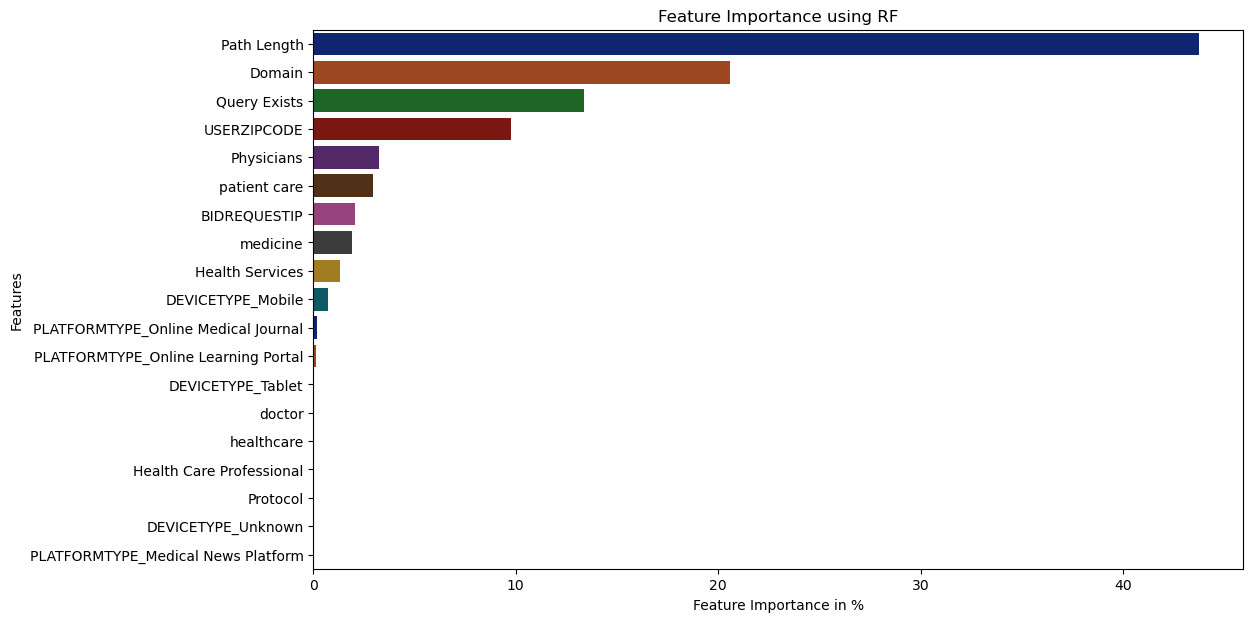

In [79]:
x=pd.DataFrame(rf_model.feature_importances_*100,index=X_train.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x[0],x.index,palette='dark')
plt.xlabel('Feature Importance in %')
plt.ylabel('Features')
plt.title('Feature Importance using RF')
plt.show()

In [80]:
df_train1=df_train.copy()
df_test1=df_test.copy()

In [81]:
df_train1.head()

,BIDREQUESTIP,USERZIPCODE,IS_HCP,Protocol,Domain,Path Length,Query Exists,healthcare,doctor,medicine,patient care,Health Care Professional,Health Services,Physicians,DEVICETYPE_Mobile,DEVICETYPE_Tablet,DEVICETYPE_Unknown,PLATFORMTYPE_Medical News Platform,PLATFORMTYPE_Online Learning Portal,PLATFORMTYPE_Online Medical Journal
0,2863464470,97206.0,0.0,1,668,36,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,1104739609,22202.0,0.0,1,668,69,0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,1122520854,83654.0,0.0,1,668,36,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,2932533091,77008.0,0.0,1,779,90,0,0,0,1,0,0,0,0,1,0,0,0,0,1
5,406561774,13215.0,0.0,1,779,84,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [82]:
df_train1.columns

Index(['BIDREQUESTIP', 'USERZIPCODE', 'IS_HCP', 'Protocol', 'Domain',
       'Path Length', 'Query Exists', 'healthcare', 'doctor', 'medicine',
       'patient care', 'Health Care Professional', 'Health Services',
       'Physicians', 'DEVICETYPE_Mobile', 'DEVICETYPE_Tablet',
       'DEVICETYPE_Unknown', 'PLATFORMTYPE_Medical News Platform',
       'PLATFORMTYPE_Online Learning Portal',
       'PLATFORMTYPE_Online Medical Journal'],
      dtype='object')

In [83]:
df_test1.columns

Index(['BIDREQUESTIP', 'is_duplicate', 'Protocol', 'Domain', 'Path Length',
       'Query Exists', 'healthcare', 'doctor', 'medicine', 'patient care',
       'Health Care Professional', 'Health Services', 'Physicians',
       'DEVICETYPE_Mobile', 'DEVICETYPE_Tablet', 'DEVICETYPE_Unknown',
       'PLATFORMTYPE_Medical News Platform',
       'PLATFORMTYPE_Online Learning Portal',
       'PLATFORMTYPE_Online Medical Journal'],
      dtype='object')

In [84]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [85]:
X1 = df_train1.drop(['IS_HCP'],axis = 1)
y1 = df_train1['IS_HCP']

In [86]:
X1.shape

(107575, 19)

In [87]:
from sklearn.model_selection import train_test_split
X1_train, X1_validation, y1_train, y1_validation = train_test_split(X1,y1,test_size = 0.2,random_state = 0)

In [88]:
param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [38],
    'max_features': [19],
    'min_samples_leaf': [5],
    'min_samples_split': [14],
    'n_estimators': [100]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search_rfcl = GridSearchCV(estimator = rfcl, param_grid = param_grid,n_jobs=-1, cv = 5)

In [89]:
grid_search_rfcl.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [38],
                         'max_features': [16], 'min_samples_leaf': [5],
                         'min_samples_split': [14], 'n_estimators': [100]})

In [90]:
grid_search_rfcl.best_params_

{'criterion': 'entropy',
 'max_depth': 38,
 'max_features': 16,
 'min_samples_leaf': 5,
 'min_samples_split': 14,
 'n_estimators': 100}

In [91]:
rf_model1 = grid_search_rfcl.best_estimator_

In [92]:
y_pred_train = rf_model1.predict(X1_train)
y_pred_val = rf_model1.predict(X1_validation)

In [93]:
from sklearn import metrics
rf_acc_train = metrics.accuracy_score(y1_train,y_pred_train)
rf_acc_val = metrics.accuracy_score(y_validation,y_pred_val)
print("Train Accuracy:",rf_acc_train)
print("Validation Accuracy:",rf_acc_val)
print()

rf_roc_train = metrics.roc_auc_score(y1_train,y_pred_train)
rf_roc_val = metrics.roc_auc_score(y_validation,y_pred_val)
print("Train ROC AUC score:",rf_roc_train)
print("Validation ROC AUC score:",rf_roc_val)
print()

rf_clr_train = metrics.classification_report(y1_train,y_pred_train)
rf_clr_val = metrics.classification_report(y_validation,y_pred_val)
print("Train Classification Report:\n",rf_clr_train)
print("Validation Classification Report:\n",rf_clr_val)

Train Accuracy: 0.9875900534510806
Validation Accuracy: 0.979874506158494

Train ROC AUC score: 0.9827074674376359
Validation ROC AUC score: 0.9728116723796241

Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     60192
         1.0       0.99      0.97      0.98     25868

    accuracy                           0.99     86060
   macro avg       0.99      0.98      0.99     86060
weighted avg       0.99      0.99      0.99     86060

Validation Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     15025
         1.0       0.98      0.96      0.97      6490

    accuracy                           0.98     21515
   macro avg       0.98      0.97      0.98     21515
weighted avg       0.98      0.98      0.98     21515



In [94]:
#after hypertuning
models = {"Random Forest": RandomForestClassifier()}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X1_train, y1_train)
    y1_pred = model.predict(X1_validation)
    accuracy = accuracy_score(y1_validation, y1_pred)
    print(f"{model_name} accuracy: {accuracy}")


Random Forest accuracy: 0.9840111550081339


In [95]:
df2=pd.DataFrame(rf_model1.feature_importances_*100,index=X_train.columns).sort_values(by=0,ascending=False)
df2

,0
Path Length,44.591188
Domain,20.313331
USERZIPCODE,11.159161
Query Exists,7.928847
BIDREQUESTIP,5.690870
Physicians,3.276506
patient care,1.947553
medicine,1.927455
Health Services,1.336226
DEVICETYPE_Mobile,0.910542


In [96]:
final_predictions = dt_model.predict(df_test)
submission=pd.DataFrame([test_file_ids,final_predictions]).T
submission.rename(columns={"Unnamed 0": "IS_HCP"},inplace=True)
submission.to_csv('Output_File_dt.csv',index = False)

In [97]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
#To install xgboost library use - 
!pip install xgboost 
from xgboost import XGBClassifier

Defaulting to user installation because normal site-packages is not writeable


In [98]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [99]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_validation)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_validation,y_validation)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_validation,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_validation,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        

    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_validation,y_validation))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_validation,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_validation,pred_test))
    
    return score_list

In [100]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.8251684871020218
Accuracy on test set :  0.8233325586799907
Recall on training set :  0.5104762641100974
Recall on test set :  0.5092449922958397
Precision on training set :  0.8471259943546318
Precision on test set :  0.842897220096914


In [101]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [102]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  0.8636648849639786
Accuracy on test set :  0.863304671159656
Recall on training set :  0.5868254213700325
Recall on test set :  0.5902927580893682
Precision on training set :  0.9355932203389831
Precision on test set :  0.9314369073668854


In [103]:
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [104]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score=get_metrics_score(xgb) 

Accuracy on training set :  0.9699279572391355
Accuracy on test set :  0.9632349523588194
Recall on training set :  0.9228776867171795
Recall on test set :  0.9075500770416025
Precision on training set :  0.9757622823510177
Precision on test set :  0.968590692320342


In [105]:
#final_predictions = xgb.predict(df_test)
#submission=pd.DataFrame([test_file_ids,final_predictions]).T
#submission.rename(columns={"is_hcp": "IS_HCP"},inplace=True)
#submission.to_csv('Submit_new_xgb1.csv',index = False)

In [106]:
### LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model=LinearDiscriminantAnalysis()

In [107]:
LDA_model=model.fit(X_train,y_train)

In [108]:
LDA_model.score(X_train, y_train)

0.7814199395770393

In [109]:
LDA_model.score(X_validation, y_validation)

0.7787590053451081

In [110]:
pred_class_train = LDA_model.predict(X_train)

pred_class_test = LDA_model.predict(X_validation)

In [111]:
print('Classification Report of the training data:\n\n',metrics.classification_report(y_train,pred_class_train),'\n')
print('Classification Report of the test data:\n\n',metrics.classification_report(y_validation,pred_class_test),'\n')

Classification Report of the training data:

               precision    recall  f1-score   support

         0.0       0.78      0.96      0.86     60192
         1.0       0.81      0.36      0.49     25868

    accuracy                           0.78     86060
   macro avg       0.79      0.66      0.68     86060
weighted avg       0.79      0.78      0.75     86060
 

Classification Report of the test data:

               precision    recall  f1-score   support

         0.0       0.78      0.96      0.86     15025
         1.0       0.80      0.35      0.49      6490

    accuracy                           0.78     21515
   macro avg       0.79      0.66      0.67     21515
weighted avg       0.78      0.78      0.75     21515
 



In [112]:
##ADA BOOST

In [113]:
from sklearn.ensemble import AdaBoostClassifier
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)

In [114]:
ADB_model.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=1)

In [115]:
## Performance Matrix on train data set
y_train_predict = ADB_model.predict(X_train)
model_score_ADB_train = ADB_model.score(X_train, y_train)
print(model_score_ADB_train)
print(metrics.confusion_matrix(y_train, y_train_predict))
print("ADB_train")
print(metrics.classification_report(y_train, y_train_predict))

0.8348710202184523
[[57796  2396]
 [11815 14053]]
ADB_train
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     60192
         1.0       0.85      0.54      0.66     25868

    accuracy                           0.83     86060
   macro avg       0.84      0.75      0.78     86060
weighted avg       0.84      0.83      0.82     86060



In [116]:
## Performance Matrix on test data set
y_test_predict = ADB_model.predict(X_validation)
model_score_ADB_test = ADB_model.score(X_validation, y_validation)
print(model_score_ADB_test)
print(metrics.confusion_matrix(y_validation, y_test_predict))
print("ADB_test")
print(metrics.classification_report(y_validation, y_test_predict))

0.8329537531954451
[[14412   613]
 [ 2981  3509]]
ADB_test
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     15025
         1.0       0.85      0.54      0.66      6490

    accuracy                           0.83     21515
   macro avg       0.84      0.75      0.78     21515
weighted avg       0.84      0.83      0.82     21515



In [117]:
from sklearn.metrics import accuracy_score

# Instantiate different models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "ADB": AdaBoostClassifier(),
    "LDA":LinearDiscriminantAnalysis(),
    "XGB": GradientBoostingClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    print(f"{model_name} accuracy: {accuracy*100}")


Decision Tree accuracy: 98.79618870555427
Random Forest accuracy: 98.36858006042296
ADB accuracy: 82.33325586799907
LDA accuracy: 77.8759005345108
XGB accuracy: 86.3304671159656


In [118]:
#after hypertuning
models = {"Random Forest": RandomForestClassifier()}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X1_train, y1_train)
    y1_pred = model.predict(X1_validation)
    accuracy = accuracy_score(y1_validation, y1_pred)
    print(f"{model_name} accuracy: {accuracy}")


Random Forest accuracy: 0.9839181966070184
